<a href="https://colab.research.google.com/github/giuliofortini/NLP_SQuAD_Project/blob/gpt/SQUAD_evaluating_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [10]:
import json
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

!pip install nltk --upgrade
import nltk
from nltk.translate import nist_score, bleu_score, meteor_score
nltk.download('wordnet')
nltk.download('punkt') 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

!pip install transformers
import transformers
from transformers import BertTokenizer, TFBertModel
transformers.logging.set_verbosity_error() # suppress tokenizer sentences' length warnings

import keras
from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Flatten, Dropout, Activation

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Requirement already up-to-date: nltk in /usr/local/lib/python3.7/dist-packages (3.5)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#1) Generated questions evaluation

##Utils

In [11]:
def paragraph(text, max_width=80, indent=0):
  if len(text) > max_width:
    cut = max_width
    while text[cut] != " ": cut -= 1
    return " "*indent + text[:cut].strip() + "\n" + paragraph(text[cut:], max_width, indent=indent)
  else:
    return " "*indent + text.strip()

    
def remove_tags(text):
  return (text.
          replace("[CTX]", "").
          replace("[QS]", "").
          replace("[QE]", "").
          strip())

In [12]:
sample_context = "Bidirectional Encoder Representations from Transformers (BERT) is a Transformer based machine learning technique for natural language processing (NLP) pre-training developed by Google. BERT was created and published in 2018 by Jacob Devlin and his colleagues from Google."
sample_questions = [# correct quenstions
                    "What is BERT?", 
                    "What is bert based on?", 
                    "Who released BERT two years ago?",
                    "Who published BERT in last two years?",
                    "What company did the creator of bert work for?",
                    "Who made BERT?",
                    "When did Dante Alighieri die?",
                    "Where is Alma Mater Studiorum?",
                    "Who created Rick and Morty?",
                    ]

print(f"Sample context:\n{paragraph(remove_tags(sample_context), indent=2)}\n\nSample questions:")
for q in sample_questions:
  print("-", q)

Sample context:
  Bidirectional Encoder Representations from Transformers (BERT) is a Transformer
  based machine learning technique for natural language processing (NLP)
  pre-training developed by Google. BERT was created and published in 2018 by
  Jacob Devlin and his colleagues from Google.

Sample questions:
- What is BERT?
- What is bert based on?
- Who released BERT two years ago?
- Who published BERT in last two years?
- What company did the creator of bert work for?
- Who made BERT?
- When did Dante Alighieri die?
- Where is Alma Mater Studiorum?
- Who created Rick and Morty?


##Metrics definition

In [100]:
from nltk.translate import bleu_score, nist_score, meteor_score
from nltk.corpus import wordnet
import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE


stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

# # STANDARDS # # # # # # 
def bleu(reference, text):
  return bleu_score.sentence_bleu([reference], text)

def nist(reference, text):
  return nist_score.sentence_nist(reference, text)

def meteor(reference, text): 
  return meteor_score.single_meteor_score(reference, text)

def rouge1(a, b):
  set_a = set(normalize(a))
  set_b = set(normalize(b))
  return len(set_a.intersection(set_b)) / len(set_b)


# # PROPOSED # # # # # # 
def get_synonims(word):
  syn_set = set()
  for syn in wordnet.synsets(word):
    syn_set = syn_set.union(set(lemma.name() for lemma in syn.lemmas()))
  return syn_set if syn_set != [] else {word}


def reformulate_sentence(sentence, verbose=False):
  alternatives = [sentence]
  for word in sentence.split(" "):
    if verbose: print(f"\n{word}...........")
    synonims = get_synonims(word)
    for syn in synonims:
      altern = sentence.replace(word, syn.lower().replace("_", " "))
      if verbose: print(altern)
      alternatives.append(altern)
  return alternatives


def proposed(reference, sentence, verbose=False):
  scores = []
  if verbose: print("\n", sentence)
  for alternative in reformulate_sentence(sentence):
    score = rouge1(reference, alternative)
    if verbose: print(score, alternative)
    scores.append((score, alternative))
  
  return max(scores)[0] 


# # # #  PERPLEXITY # # # # # # # 
def build_perplexity_lm(train_sentences, n=1):
  from nltk.lm import Vocabulary
  print("\n\nbuild perplexity:\ntrain: ", np.array(train_sentences).shape)
  tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                  for sent in train_sentences]
  train_data, _ = padded_everygram_pipeline(n, tokenized_text)
  model = MLE(n)
  print("Fitting MLE... ", end="")
  vocab = Vocabulary(nltk.tokenize.word_tokenize(' '.join(train_sentences)), n);

  model.fit(train_data, vocab)
  print("done.")
  return model

def predict_perplexity(model, test, n=3):
  test_sentences = [test] if type(test) != list else test
  tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                  for sent in test_sentences]

  test_data, _ = padded_everygram_pipeline(n, tokenized_text)
  scores = []
  for i, test in enumerate(test_data):
    scores.append(model.score(test))

  return sum(scores) / len(scores)

## Testing Metrics

In [108]:
from sklearn.metrics import mean_squared_error as mse

def plot_scores(df):
  fig, axs = plt.subplots(2, 1, figsize=(12, 10))
  x = list(range(len(df)))
  for col in df.columns[:-1]:
    axs[0].plot(x, list(df[col]), label=col)
  
  axs[1].plot(x, list(df[df.columns[-1]]), label=df.columns[-1])
  axs[1].plot(x, [df[df.columns[-1]].mean() for _ in x], label="avg "+df.columns[-1])
  
  axs[0].legend()
  axs[1].legend()
  plt.show()


def evaluate(questions, human_val, plm):
  results_df = pd.DataFrame(columns = ["bleu", "nist", "meteor", "rouge", "proposed", "human", "perplexity"])
  total = len(questions)
  
  for i, context in enumerate(questions):
    print(f"\rEvaluating context {i+1}/{total}", end="")
    for question in questions[context]:
      results_df = results_df.append(
          pd.DataFrame([[round(bleu(context, question), 3),
                         round(nist(context, question), 3),
                         round(meteor(context, question), 3),
                         round(rouge1(context, question), 3),
                         round(proposed(context, question), 3),
                         human_val[question]["contextuality"],
                         perplexity(question, plm)
                         ]], 
                      columns = results_df.columns,
                      index = [question]))
  #print("\r ")
  results_df = results_df.sort_values(by="human")
  plot_scores(results_df)

  #compute mse
  print("\n{:<15} MLE\n{}".format("", "-"*25))
  for col in results_df.columns[:-1]:
    err = mse(results_df[col].values, results_df["human"].values )
    print("{:15} {}".format(col, round(err, 3)))
  return results_df



build perplexity:
train:  (9,)
Fitting MLE... done.
Evaluating context 1/1

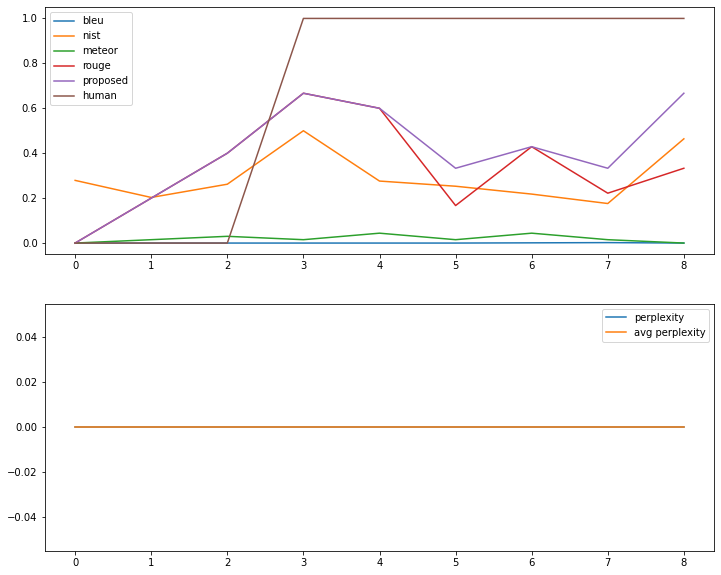


                MLE
-------------------------
bleu            0.666
nist            0.344
meteor          0.638
rouge           0.282
proposed        0.2
human           0.0


,bleu,nist,meteor,rouge,proposed,human,perplexity
When did Dante Alighieri die?,0.000,0.279,0.000,0.000,0.000,0,0.0
Where is Alma Mater Studiorum?,0.000,0.203,0.015,0.200,0.200,0,0.0
Who created Rick and Morty?,0.000,0.262,0.030,0.400,0.400,0,0.0
What is BERT?,0.000,0.500,0.015,0.667,0.667,1,0.0
What is bert based on?,0.000,0.276,0.044,0.600,0.600,1,0.0
Who released BERT two years ago?,0.000,0.253,0.015,0.167,0.333,1,0.0
Who published BERT in last two years?,0.001,0.218,0.044,0.429,0.429,1,0.0
What company did the creator of bert work for?,0.002,0.176,0.015,0.222,0.333,1,0.0
Who made BERT?,0.000,0.464,0.000,0.333,0.667,1,0.0


In [101]:
sample_plm = build_perplexity_lm(sample_questions)
sample_humans = {}
for quest, cont_score in zip(sample_questions, [1,1,1,1,1,1,0,0,0]):
  sample_humans[quest] = {"contextuality": cont_score}
  
sample_scores_df = evaluate({sample_context: sample_questions}, sample_humans, sample_plm)
sample_scores_df.head(20)

## Evaluating the Test Set

In [22]:
with open("/content/drive/MyDrive/SQUAD/SQUAD/240_generated_questions.json", encoding="utf-8") as f:
  test_questions = json.load(f)

test_humans = pd.read_csv("/content/drive/MyDrive/SQUAD/SQUAD/human_judgements.csv", sep="##", index_col=["question"])
print(test_humans.head())
test_humans = test_humans.to_dict(orient="index")

                                                    grammar  ...   score
question                                                     ...        
What is Bern on?                                        1.0  ...  1.0000
Where is the old observatory located?                   1.0  ...  1.0000
Which location is the old observatory in Bern?          1.0  ...  1.0000
Along with Gurten, Bantiger, what was the old o...      0.5  ...  0.4375
What is another name for the old observatory?           1.0  ...  0.6250

[5 rows x 4 columns]


In [165]:
test_contexts = []
test_real_question = []
test_generated_questions = []
with open("/content/drive/MyDrive/SQUAD/test_samples.txt") as f:
  for line in f.read().replace("\n", "").split("[CTX]"):
    print(line)
    input()
print("Training samples: ", len(test_generated_questions))



 The Order of Preachers (Latin: Ordo Praedicatorum, hence the abbreviation OP used by members), more commonly known after the 15th century as the Dominican Order or Dominicans, is a Roman Catholic religious order founded by the Spanish priest Saint Dominic de Guzman in France and approved by Pope Honorius III (1216–27) on 22 December 1216. Membership in this "mendicant" order includes friars, nuns, active sisters, and lay or secular Dominicans (formerly known as tertiaries, though recently there has been a growing number of Associates, who are unrelated to the tertiaries) affiliated with the order. [QS] What is the Latin for Order of Preachers?[QE]

 The Order of Preachers (Latin: Ordo Praedicatorum, hence the abbreviation OP used by members), more commonly known after the 15th century as the Dominican Order or Dominicans, is a Roman Catholic religious order founded by the Spanish priest Saint Dominic de Guzman in France and approved by Pope Honorius III (1216–27) on 22 December 1216

KeyboardInterrupt: ignored

['Where does migration mainly occur?', 'Why do birds primarily migrate?']



build perplexity:
train:  (49938,)
Fitting MLE... done.
Evaluating context 48/48

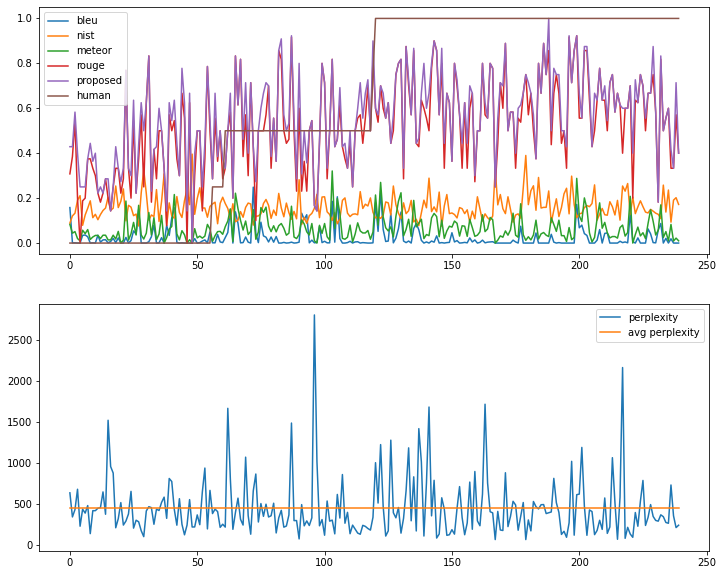


                MLE
-------------------------
bleu            0.537
nist            0.392
meteor          0.481
rouge           0.139
proposed        0.135
human           0.0


,bleu,nist,meteor,rouge,proposed,human,perplexity
What is an estimate of the proportion of American children aged 0–18 years per year?,0.158,0.089,0.083,0.308,0.429,0.0,632.893867
What name was used to describe the walls built on top of the medieval wall?,0.001,0.121,0.044,0.385,0.429,0.0,338.430475
How old was the Zytglogge tower located between the Rhine and Rhyni?,0.001,0.133,0.051,0.545,0.583,0.0,428.287043
What did the plague plague affect?,0.000,0.191,0.020,0.200,0.400,0.0,676.617758
When was Plymouth destroyed?,0.000,0.211,0.010,0.000,0.250,0.0,225.021130
...,...,...,...,...,...,...,...
How many members are elected?,0.000,0.236,0.010,0.600,0.600,1.0,260.861011
What percent of the City Councils have voted in favour of the Socialist reforms?,0.019,0.093,0.083,0.333,0.417,1.0,728.879270
What group controls government of Bern?,0.000,0.191,0.009,0.333,0.333,1.0,352.355545
What is a five-bedroom apartment in Bern?,0.000,0.202,0.022,0.571,0.714,1.0,208.239306


In [109]:
test_plm = build_perplexity_lm(train_question_list)
#evaluate(test_questions, test_humans, test_plm)
evaluate(test_questions, test_humans, model)

#2) Answering the generated questions 😲

## Model

In [10]:
def build_model():

  # Define Input layers
  input_ids_layer = Input(shape = (512,), dtype='int64')
  attention_mask_layer = Input(shape = (512,), dtype='int64')
  token_ids_layer = Input(shape = (512,), dtype='int64')

  # Load Bert model
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  
  bert_model.trainable = True
  
  # Initialize bert model
  bert = bert_model([input_ids_layer,
                    attention_mask_layer,
                    token_ids_layer],
                    return_dict = False,
                    output_attentions = False,
                    output_hidden_states = False
                    ).last_hidden_state
  
  # Dropout
  dropout = Dropout(0.2)(bert)

  # Classifiers
  start_classifier = Dense(units=1, name="Start_classifier")(dropout)
  end_classifier = Dense(units=1, name="End_classifier")(dropout)

  # Flatteners
  start_flat = Flatten(name="start_flattener")(start_classifier)
  end_flat = Flatten(name="end_flattener")(end_classifier)

  # Activations
  start_softmax = Activation(tf.keras.activations.softmax, name="start")(start_flat)
  end_softmax = Activation(tf.keras.activations.softmax, name="end")(end_flat)

  # Build model
  model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
                outputs=[start_softmax, end_softmax])
  
  model.summary()
  return model

model = build_model()
plot_model(model, show_shapes=True)

LOADING_EPOCH = 3
model.load_weights(f'/content/drive/MyDrive/SQUAD/SQUAD/weights_epoch_{LOADING_EPOCH}.h5')


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]               

## Load generated questions

In [11]:
import json
with open("/content/drive/MyDrive/SQUAD/SQUAD/240_generated_questions.json", encoding="utf-8") as f:
  context_questions_dict = json.load(f)

## Input tokenization

In [12]:
# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split

In [13]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:

def prepare_input(context_questions_dict):
  SEQUENCE_LIMIT = 512
  STRIDE = 256
  data = {}
  for context in context_questions_dict:
    # initialize structures
    encoded_context = tokenizer.encode(context)

    for question in context_questions_dict[context]:
      input_ids = []
      input_mask = []
      input_type_ids = []
      # encode question and context
      encoded_question = tokenizer.encode(question)

      # concatenate input data 
      if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
        # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
        encoded_contexts = split_long_sequence(encoded_context,
                                                limit=SEQUENCE_LIMIT-len(encoded_question), 
                                                stride=STRIDE)
      else:
        encoded_contexts = [encoded_context]
      
      # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
      for context_piece in encoded_contexts:
        
        encoded_input = encoded_question + context_piece

        # create mask of ones
        ones_mask = tf.ones_like(encoded_input)

        # add padding and convert to tensor
        encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
        encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))

        # create input_type_ids
        type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                              tf.ones_like(context_piece, dtype=tf.int32)], 
                            axis=-1)
        
        type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
        type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))

        # create mask of zeros
        zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
        mask = tf.concat([zeros_mask, ones_mask], axis=-1)

        # append elements to lists
        input_ids.append(encoded_input)
        input_mask.append(mask)
        input_type_ids.append(type_ids)

      # save input data as dictionary
      data[question] = {
        'input_ids': tf.convert_to_tensor(input_ids),
        'attention_mask': tf.convert_to_tensor(input_mask),
        'token_type_ids': tf.convert_to_tensor(input_type_ids)
        }
  return data

In [15]:
data = prepare_input(context_questions_dict)

## Prediction on Test Set

In [16]:
# Predict test set
def find_answers(data):
  results = {}
  total = len(data)
  for i, question in enumerate(data):
    print(f"\rPredicting {i+1}/{total}", end="")

    pred = model.predict([data[question]["input_ids"], 
                          data[question]["attention_mask"], 
                          data[question]["token_type_ids"]])
    
    pred_start_ids = np.argmax(pred[0], axis=-1)
    pred_end_ids = np.argmax(pred[1], axis=-1)
    
    results[question] = {
        "start_id" : pred_start_ids,
        "end_id": pred_end_ids
        }
  return results

results = find_answers(data)

Predicting 239/239

## Output

In [17]:
def paragraph(text, max_width=80, indent=0):
  if len(text) > max_width:
    cut = max_width
    while text[cut] != " ": cut -= 1
    return " "*indent + text[:cut].strip() + "\n" + paragraph(text[cut:], max_width, indent=indent)
  else:
    return " "*indent + text.strip()

In [18]:
from sklearn.metrics import confusion_matrix


CONTEXT:
The city of Bern or Berne (German: Bern, pronounced [bɛrn] ( listen); French:
Berne [bɛʁn]; Italian: Berna [ˈbɛrna]; Romansh: Berna  [ˈbɛrnɐ] (help·info);
Bernese German: Bärn [b̥æːrn]) is the de facto capital of Switzerland, referred
to by the Swiss as their (e.g. in German) Bundesstadt, or "federal city".[note
1] With a population of 140,634 (November 2015), Bern is the fifth most
populous city in Switzerland. The Bern agglomeration, which includes 36
municipalities, had a population of 406,900 in 2014. The metropolitan area had
a population of 660,000 in 2000. Bern is also the capital of the Canton of
Bern, the second most populous of Switzerland's cantons.

QUESTION                                                                        HUMAN     ANSWER:
How many municipalities does the cantons of Bern possess?.......................1.0       36
How many municipalities are on the Bernier-Stadt-Saar region?...................0.5       36
How many municipalities are there in

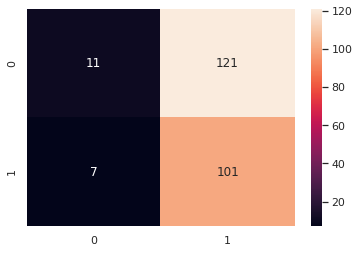

In [19]:
def get_text_from_token_ids(context, start_id, end_id):
  return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(context[start_id:end_id+1]))


def report(data, results, context_dict, humans=None):
  pred_answerability = []
  true_answerability = []

  for context in context_dict:
    print("\n{}\nCONTEXT:".format("="*100))
    print(paragraph(context))

    print("\n{:<80}{:10}{}".format('QUESTION', "HUMAN", 'ANSWER:'))

    questions = context_dict[context]
    for question in questions:
      input_ids   = data[question]['input_ids'][0]
      pred_start  = results[question]['start_id'][0]
      pred_end    = results[question]['end_id'][0]

      if (not pred_start == 0 and 
          not pred_end == 0 and 
          pred_end >= pred_start):  predicted_answer = get_text_from_token_ids(input_ids, pred_start, pred_end)
      else:                         predicted_answer = "<NOT FOUND>"
      
      if humans != None:  
        true_answerability.append(humans[question]["answ"] >= 0.5) # consider the question as answerable if the answerability score is over 0.5 (at least half of the human votes)
        pred_answerability.append(predicted_answer != "<NOT FOUND>")
      else:               
        answerability = " - "
      
      print("{:.<80}{:<10}{}".format(paragraph(question), humans[question]["answ"], predicted_answer))
    
  print("\n\n")
  print(classification_report(true_answerability, pred_answerability))
  import seaborn as sn
  sn.set(font_scale=1) # for label size
  cm = confusion_matrix(true_answerability, pred_answerability)
  sn.heatmap(cm, annot=True, fmt="d")
  plt.show()
  
human_val = pd.read_csv("/content/drive/MyDrive/SQUAD/SQUAD/human_judgements.csv", sep="##")
test_humans = {}
for row in human_val.iterrows():
  test_humans[row[1]["question"]] = {
      "gram": row[1]["grammar"],
      "cont": row[1]["contextuality"],
      "answ": row[1]["answerability"]
  }

report(data, results, context_questions_dict, test_humans)

## Demo! 

Predicting 4/4
CONTEXT:
Bert is a transformer based architecture. It is very good at understanding
natural language. It is very heavy, tho.

QUESTION                                                                        HUMAN     ANSWER:
What is Bert?...................................................................1.0       a transformer based architecture
What can it do?.................................................................1.0       understanding natural language
How is it in terms of weight?...................................................1.0       very heavy
Who created Rick and Morty?.....................................................0.0       transformer



              precision    recall  f1-score   support

       False       0.00      0.00      0.00         1
        True       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      

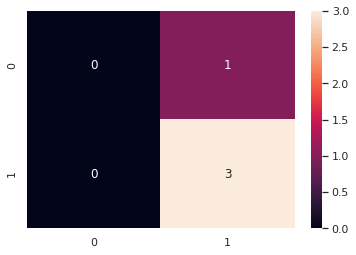

In [20]:
context = "Bert is a transformer based architecture. It is very good at understanding natural language. It is very heavy, tho. "#@param{type:"string"}
question_1 = "What is Bert? "#@param{type:"string"}
question_2 = "What can it do? "#@param{type:"string"}
question_3 = "How is it in terms of weight? "#@param{type:"string"}
question_4 = "Who created Rick and Morty? "#@param{type:"string"}

demo_dict = {context: [question_1, 
                       question_2, 
                       question_3,
                       question_4]
             }

assert (context != ""), "Insert a context!"
assert ((question_1 != "") or
        (question_2 != "") or
        (question_3 != "") or
        (question_4 != "")), "Insert at least one question with an answer"

# prepare input
data_demo = prepare_input(demo_dict)
results_demo = find_answers(data_demo)
human_demo = { question_1: {"answ": 1.0}, question_2: {"answ": 1.0}, question_3: {"answ": 1.0}, question_4: {"answ": 0.0}}
report(data_demo, results_demo, demo_dict, human_demo)

#Perplexity cazzo

In [ ]:
my_lm = build_perplexity_lm(train_question_list)

In [84]:

#here you construct the unigram language model 
def unigram(tokens):    
  model = collections.defaultdict(lambda: 0.01)
  for f in tokens:
    try:
      model[f] += 1
    except KeyError:
      model[f] = 1
      continue
  N = float(sum(model.values()))
  for word in model:
    model[word] = model[word]/N
  return model

In [85]:
#computes perplexity of the unigram model on a testset  
def perplexity(testset, model):
  testset = testset.split()
  perplexity = 1
  N = 0
  for word in testset:
    N += 1
    perplexity = perplexity * (1/model[word])
  perplexity = pow(perplexity, 1/float(N)) 
  return perplexity

In [159]:
test_contexts =  list(test_questions.keys())
test_questions = [item for sublist in test_questions.values() for item in sublist]



test contexts
 ['The city of Bern or Berne (German: Bern, pronounced [bɛrn] ( listen); French: Berne [bɛʁn]; Italian: Berna [ˈbɛrna]; Romansh: Berna  [ˈbɛrnɐ] (help·info); Bernese German: Bärn [b̥æːrn]) is the de facto capital of Switzerland, referred to by the Swiss as their (e.g. in German) Bundesstadt, or "federal city".[note 1] With a population of 140,634 (November 2015), Bern is the fifth most populous city in Switzerland. The Bern agglomeration, which includes 36 municipalities, had a population of 406,900 in 2014. The metropolitan area had a population of 660,000 in 2000. Bern is also the capital of the Canton of Bern, the second most populous of Switzerland\'s cantons.', 'The official language of Bern is (the Swiss variety of Standard) German, but the main spoken language is the Alemannic Swiss German dialect called Bernese German.', 'In 1983 the historic old town in the centre of Bern became a UNESCO World Heritage Site. Bern is ranked among the world’s top ten cities for the

In [155]:
import collections, nltk
# we first tokenize the text corpus
train_corpus = ' '.join(list(test_questions.keys()))
test_corpus = list(test_questions.items())[0][0]
print(paragraph(train_corpus,))

input()
tokens = nltk.word_tokenize(train_corpus)

model = unigram(tokens)
for test in test_questions:
  print(round(perplexity(test, model), 3), test)


AttributeError: ignored